# Admissions Prediction - Comparison of Decision Tree and Linear Regression Models
## Dataset source: Graduate Amission 2 on Kaggle
https://www.kaggle.com/mohansacharya/graduate-admissions?select=Admission_Predict.csv

In [37]:
#import statements
import numpy as np 
from numpy import mean, absolute
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree
from scipy.stats import t

## Read the file

In [2]:
#Read sample file
filename = 'Admissions_files/Admission_Predict.csv'
df = pd.read_csv(filename)

In [5]:
df.nunique()

Serial No.           400
GRE Score             49
TOEFL Score           29
University Rating      5
SOP                    9
LOR                    9
CGPA                 168
Research               2
Chance of Admit       60
dtype: int64

## All feature columns are numeric so label encoding is not required

In [6]:
df.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

## Partition the data

In [9]:
cols = list(df.columns)
target_col = 'Chance of Admit '
X_cols = cols[1:-1] #Remove the Serial No and target from the feature columns

X=df[X_cols]
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6, random_state=12345)

In [10]:
N = len(df)
data = {'Training': [len(X_train), len(X_train)/N],
        'Validation': [len(X_test), len(X_test)/N]}

dfPartitionValidation = pd.DataFrame.from_dict(data, orient='index', columns=['# Records', '% Records'])
dfPartitionValidation

,# Records,% Records
Training,240,0.6
Validation,160,0.4


## Train the decision tree

In [11]:
def lowest_mse(X_train, X_test, y_train, y_test, max_depth=30,min_samples_leaf=30,max_leaf_nodes=30):
    """Prune model by testing values of max depth, min samples leaf and max leaf nodes. Return the model
    with the least complexity and lowest mean squared error"""
    mse = []
    maxDepthList = []
    minSamplesLeafList = []
    maxLeafNodes = []
    for i in range(1,max_depth):
        for j in range(2,min_samples_leaf):
            for k in range(2,max_leaf_nodes):
                dtree = DecisionTreeRegressor(random_state=0,max_depth=i, min_samples_leaf=j, max_leaf_nodes=k)
                dtree.fit(X_train, y_train)
                pred = dtree.predict(X_test)
                mse.append(mean_squared_error(y_test, pred))
                maxDepthList.append(i)
                minSamplesLeafList.append(j)
                maxLeafNodes.append(k)
    dfModels = pd.DataFrame({'mse': pd.Series(mse),
                    'max depth': pd.Series(maxDepthList),
                    'min samples leaf': pd.Series(minSamplesLeafList),
                    'max leaf nodes': pd.Series(maxLeafNodes)})
    #sort the dataframe by mse and complexity
    dfModels = dfModels.sort_values(by=['mse','max depth','min samples leaf','max leaf nodes']).reset_index()
    #return the pruned model
    prunedTree = DecisionTreeRegressor(random_state=0,max_depth=dfModels['max depth'][0], min_samples_leaf=dfModels['min samples leaf'][0], max_leaf_nodes=dfModels['max leaf nodes'][0])
    prunedTree.fit(X_train, y_train)
    return prunedTree

In [17]:
prunedTree = lowest_mse(X_train, X_test, y_train, y_test)

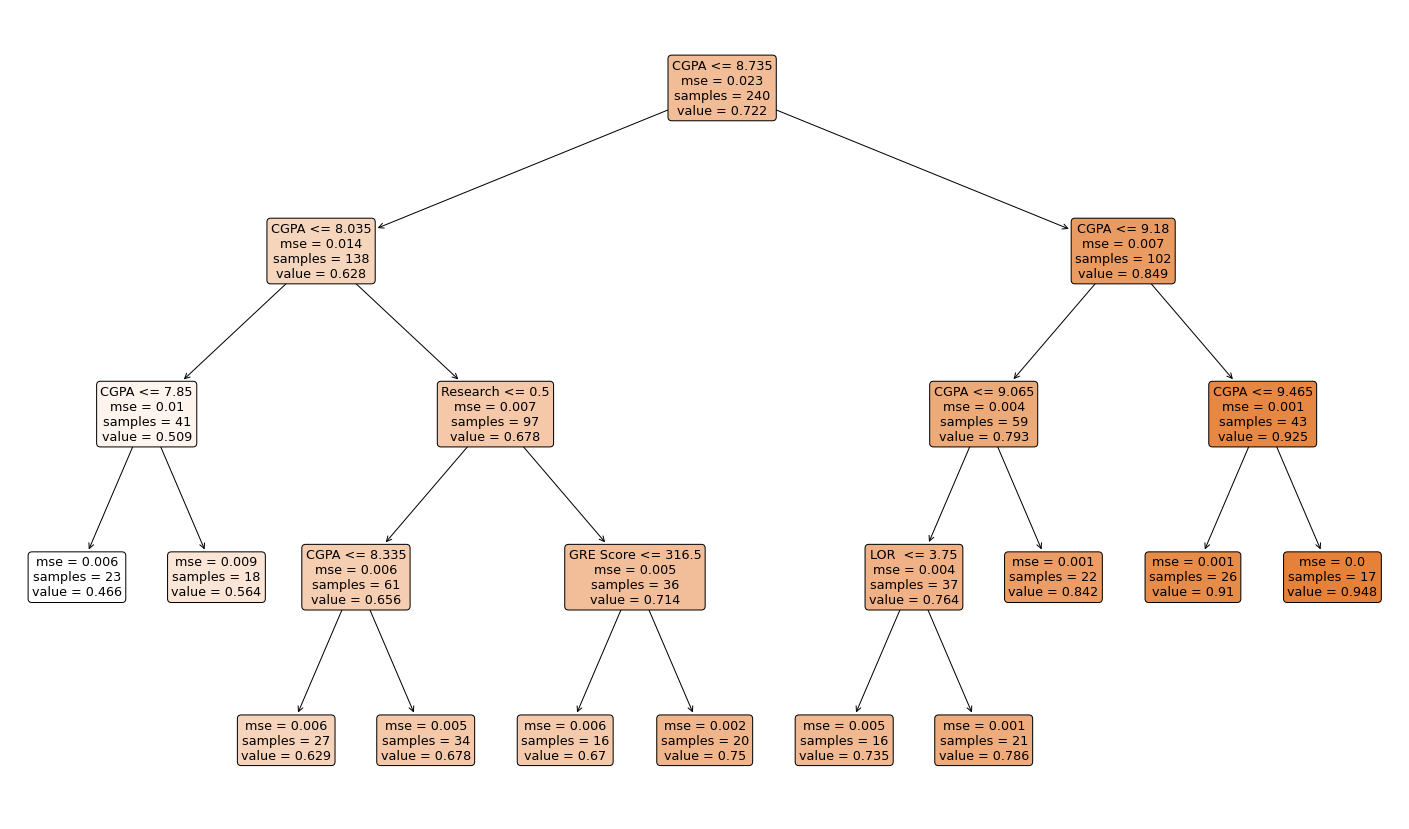

In [18]:
plt.figure(figsize=(25,15))
a = tree.plot_tree(prunedTree,
                    feature_names = list(X.columns),
                    filled = True,
                    rounded = True)

## Train the linear regression model

In [21]:
regr = LinearRegression()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)

## Display the coefficients for the linear regression model

In [27]:
#set precision to display in dataframes
pd.set_option('precision',4)

predictor = ['Intercept'] + X_cols
lrCoefficient = pd.DataFrame(zip(predictor,regr.coef_.reshape(7)),columns=['Predictor','Estimate'])
lrCoefficient

,Predictor,Estimate
0,Intercept,0.0012
1,GRE Score,0.0035
2,TOEFL Score,0.0037
3,University Rating,-0.0105
4,SOP,0.0324
5,LOR,0.1263
6,CGPA,0.0393


## Calculate error and r^2 for the Tree model

In [28]:
trainingTreeScores = pd.DataFrame(y_train.copy())
trainingTreeScores['Prediction'] = prunedTree.predict(X_train)
trainingTreeScores['Residual'] = trainingTreeScores[target_col]-trainingTreeScores['Prediction']

validationTreeScores = pd.DataFrame(y_test.copy())
validationTreeScores['Prediction'] = prunedTree.predict(X_test)
validationTreeScores['Residual'] = validationTreeScores[target_col]-validationTreeScores['Prediction']

data = {'SSE': [sum(trainingTreeScores['Residual']**2),sum(validationTreeScores['Residual']**2)],
        'MSE': [mean_squared_error(trainingTreeScores[target_col], trainingTreeScores['Prediction']), mean_squared_error(validationTreeScores[target_col], validationTreeScores['Prediction'])],
        'RMSE': [mean_squared_error(trainingTreeScores[target_col], trainingTreeScores['Prediction'])**.5, mean_squared_error(validationTreeScores[target_col], validationTreeScores['Prediction'])**.5],
        'MAD': [mean(absolute(trainingTreeScores['Residual'])),mean(absolute(validationTreeScores['Residual']))],
        'R2': [r2_score(trainingTreeScores[target_col], trainingTreeScores['Prediction']), r2_score(validationTreeScores[target_col], validationTreeScores['Prediction'])]}

dfTreeSummary = pd.DataFrame.from_dict(data, orient='index', columns=['Training', 'Validation'])
dfTreeSummary['%Difference'] = (dfTreeSummary['Training']-dfTreeSummary['Validation'])/dfTreeSummary['Training']*100
dfTreeSummary

,Training,Validation,%Difference
SSE,0.9437,0.8665,8.1831
MSE,0.0039,0.0054,-37.7254
RMSE,0.0627,0.0736,-17.3565
MAD,0.0447,0.0556,-24.2913
R2,0.8268,0.6745,18.4241


## Calculate error and R^2 for the Linear Regression model

In [29]:
trainingScores = pd.DataFrame(y_train.copy())
trainingScores['Prediction'] = regr.predict(X_train)
trainingScores['Residual'] = trainingScores[target_col]-trainingScores['Prediction']

validationScores = pd.DataFrame(y_test.copy())
validationScores['Prediction'] = regr.predict(X_test)
validationScores['Residual'] = validationScores[target_col]-validationScores['Prediction']

data = {'SSE': [sum(trainingScores['Residual']**2),sum(validationScores['Residual']**2)],
        'MSE': [mean_squared_error(trainingScores[target_col], trainingScores['Prediction']), mean_squared_error(validationScores[target_col], validationScores['Prediction'])],
        'RMSE': [mean_squared_error(trainingScores[target_col], trainingScores['Prediction'])**.5, mean_squared_error(validationScores[target_col], validationScores['Prediction'])**.5],
        'MAD': [mean(absolute(trainingScores['Residual'])),mean(absolute(validationScores['Residual']))],
        'R2': [r2_score(trainingScores[target_col], trainingScores['Prediction']), r2_score(validationScores[target_col], validationScores['Prediction'])]}

dfRegrSummary = pd.DataFrame.from_dict(data, orient='index', columns=['Training', 'Validation'])
dfRegrSummary['%Difference'] = (dfRegrSummary['Training']-dfRegrSummary['Validation'])/dfRegrSummary['Training']*100
dfRegrSummary

,Training,Validation,%Difference
SSE,0.9932,0.6583,33.7165
MSE,0.0041,0.0041,0.5748
RMSE,0.0643,0.0641,0.2878
MAD,0.0472,0.0481,-2.0225
R2,0.8177,0.7527,7.9539


## Estimate vs Estimate plots (includes creation of steyx function)

In [30]:
def steyx(y,x):
    """Determines the standard error of the predicted y value for each actual y or
    the measure of the amount of error in the prediction of y for an individual x"""
    y_mean = mean(y)
    x_mean = mean(x)

    sumYSquare = sum((y-mean(y))**2)
    sumXSquare = sum((x-mean(x))**2)

    sumDiffSquare = sum((y-mean(y))*(x-mean(x)))**2

    dof = len(y)-2

    return ((1/dof)*(sumYSquare-(sumDiffSquare/sumXSquare)))**.5


In [38]:
T = t.ppf(1-(.05/2),(len(validationTreeScores)-1))

data = {'n': [len(validationTreeScores), len(validationScores)],
        'STEYX': [steyx(validationTreeScores[target_col], validationTreeScores['Prediction']), steyx(validationScores[target_col], validationScores['Prediction'])],
        'R2': [r2_score(validationTreeScores[target_col], validationTreeScores['Prediction']), r2_score(validationScores[target_col], validationScores['Prediction'])],
        'alpha': ['5%','5%'],
        'T.INV.2T': [T, T],
        '+/- Interval': [round(T*steyx(validationTreeScores[target_col], validationTreeScores['Residual']),2), round(T*steyx(validationScores[target_col], validationScores['Residual']),2)]
        }

dfValidation = pd.DataFrame.from_dict(data, orient='index', columns=['Tree', 'Regression'])
dfValidation

,Tree,Regression
n,160,160
STEYX,0.06733,0.06045
R2,0.6745,0.7527
alpha,5%,5%
T.INV.2T,1.975,1.975
+/- Interval,0.25,0.25


In [39]:
validationTreeScores['-95% PI'] = validationTreeScores['Prediction']- T*steyx(validationTreeScores[target_col], validationTreeScores['Prediction'])
validationTreeScores['+95% PI'] = validationTreeScores['Prediction']+ T*steyx(validationTreeScores[target_col], validationTreeScores['Prediction'])

validationScores['-95% PI'] = validationScores['Prediction']- T*steyx(validationScores[target_col], validationScores['Prediction'])
validationScores['+95% PI'] = validationScores['Prediction']+ T*steyx(validationScores[target_col], validationScores['Prediction'])

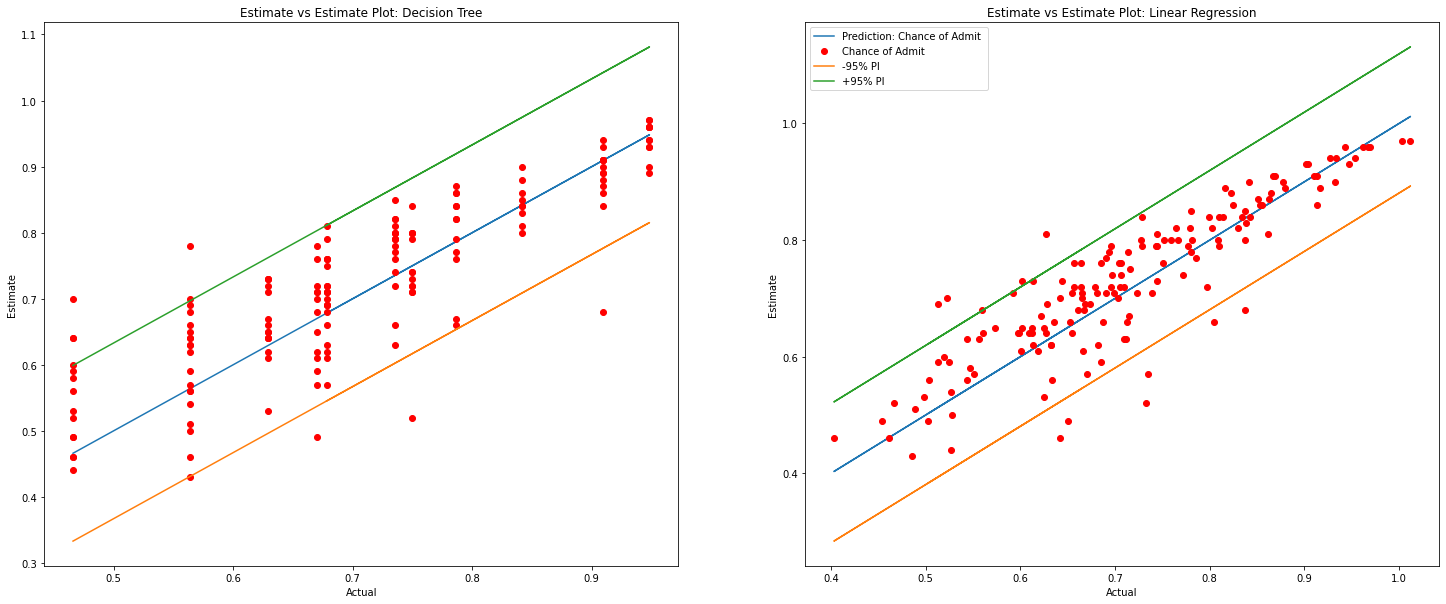

In [40]:
plt.figure(figsize=(25,10))

plt.subplot(121)

a = plt.plot(validationTreeScores['Prediction'],validationTreeScores['Prediction'],label='Prediction: {}'.format(target_col))
a1 = plt.plot(validationTreeScores['Prediction'],validationTreeScores[target_col],'ro', label=target_col)
a2 = plt.plot(validationTreeScores['Prediction'],validationTreeScores['-95% PI'],label='-95% PI')
a3 = plt.plot(validationTreeScores['Prediction'],validationTreeScores['+95% PI'],label='+95% PI')
plt.xlabel('Actual')
plt.ylabel('Estimate')
plt.title('Estimate vs Estimate Plot: Decision Tree')

plt.subplot(122)
a = plt.plot(validationScores['Prediction'],validationScores['Prediction'],label='Prediction: {}'.format(target_col))
a1 = plt.plot(validationScores['Prediction'],validationScores[target_col],'ro', label=target_col)
a2 = plt.plot(validationScores['Prediction'],validationScores['-95% PI'],label='-95% PI')
a3 = plt.plot(validationScores['Prediction'],validationScores['+95% PI'],label='+95% PI')
plt.xlabel('Actual')
plt.ylabel('Estimate')
plt.title('Estimate vs Estimate Plot: Linear Regression')

plt.legend()


## Histogram of the Residuals

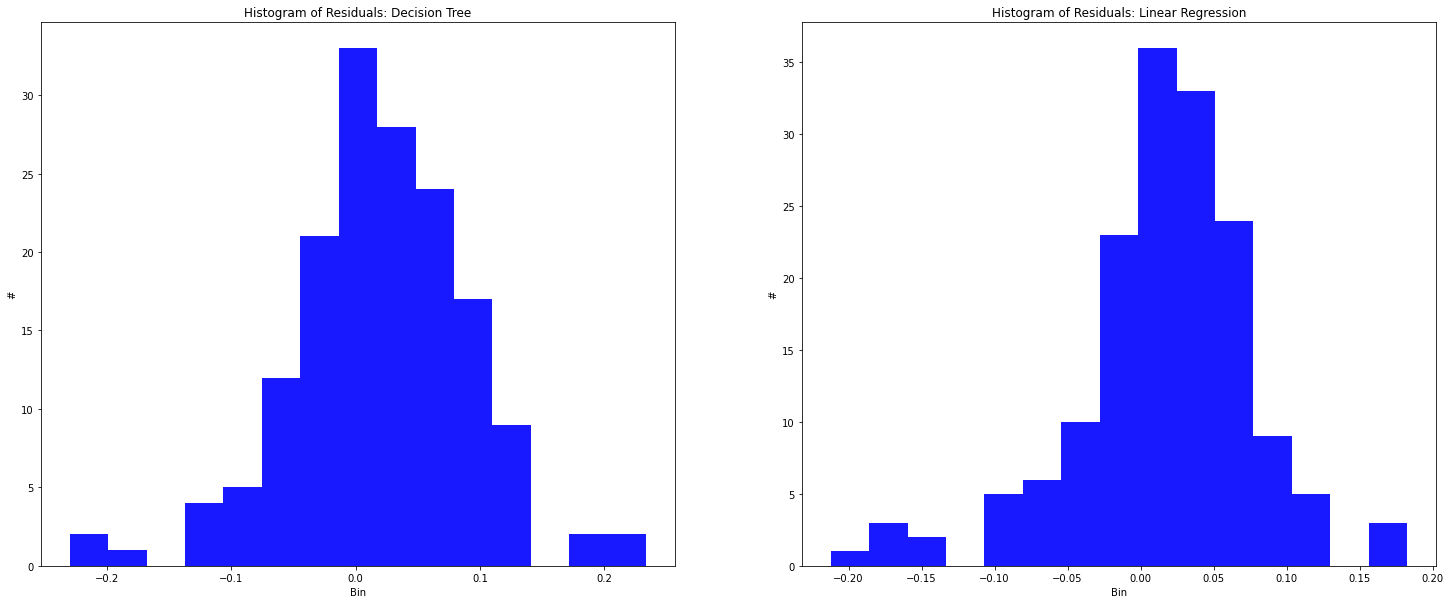

In [41]:
plt.figure(figsize=(25,10))

plt.subplot(121)
n, bins, patchs = plt.hist(validationTreeScores['Residual'], 15, facecolor='b',alpha=.9)
plt.xlabel('Bin')
plt.ylabel('#')
plt.title('Histogram of Residuals: Decision Tree')

plt.subplot(122)
n, bins, patchs = plt.hist(validationScores['Residual'], 15, facecolor='b',alpha=.9)
plt.xlabel('Bin')
plt.ylabel('#')
plt.title('Histogram of Residuals: Linear Regression')
plt.show()

## Display the difference between the Decision Tree (DT) and Linear Regression (LR) models.

In [42]:
data = {'SSE': [sum(validationTreeScores['Residual']**2),sum(validationScores['Residual']**2)],
        'MSE': [mean_squared_error(validationTreeScores[target_col], validationTreeScores['Prediction']), mean_squared_error(validationScores[target_col], validationScores['Prediction'])],
        'RMSE': [mean_squared_error(validationTreeScores[target_col], validationTreeScores['Prediction'])**.5, mean_squared_error(validationScores[target_col], validationScores['Prediction'])**.5],
        'MAD': [mean(absolute(validationTreeScores['Residual'])),mean(absolute(validationScores['Residual']))],
        'R2': [r2_score(validationTreeScores[target_col], validationTreeScores['Prediction']), r2_score(validationScores[target_col], validationScores['Prediction'])]}

dfSummary = pd.DataFrame.from_dict(data, orient='index', columns=['Validation DT', 'Validation LR'])
dfSummary['%Difference'] = round((dfSummary['Validation DT']-dfSummary['Validation LR'])/dfSummary['Validation DT']*100,2)
dfSummary

,Validation DT,Validation LR,%Difference
SSE,0.8665,0.6583,24.03
MSE,0.0054,0.0041,24.03
RMSE,0.0736,0.0641,12.84
MAD,0.0556,0.0481,13.40
R2,0.6745,0.7527,-11.60
